# Cloud statistics

Computing statistics of consecutive cloudy segments in a dataset can be challenging to implement efficiently in Python. Here are some ideas which show how this can be done in a vectorized (i.e. numpy friendly) way.

This chapter assumes that a cloud mask and possibly other cloud-related parameters are defined on a 1D trajectory as shown as blue line in the following illustration. We are interested in analysing those parameters per consecutive cloudy segment (indicated in orange).

```{figure} figures/cloud_segment_trajectory.jpg
:alt: trajectory with cloud segments
:width: 50%
:align: center
```

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])

## Cloud length

Cloud length is the distance along the trajectory from start to end of a cloudy region.
Let's look at the trajectory from above, but laid out as a straight line:
```{figure} figures/cloud_segment_track.png
:alt: cloud segment track as a straight line
:width: 100%
:align: center
```
We've got the track on the top as well as an indication of the start and end of our cloud segments.
The sensor will usually capture data in some form of pixels.
In this example, we depict non-cloudy pixels in blue and cloudy pixels in white.
We'll now assume that we know a cloud mask defined on these pixel locations which takes a value of 1 on cloudy pixels and a value of 0 on cloud free pixels:

$$
C = \begin{cases}
    1 & \text{cloudy}\\
    0 & \text{cloud free}
  \end{cases}
$$

Let's define this cloud mask according to the figure above. We'll use boolean values here and convert them to integers later on.

In [2]:
cloudmask = np.array([
    False, False,
    True, True, True, True,
    False, False, False,
    True, True,
    False, False, False, False,
    True, True, True,
    False, False
])

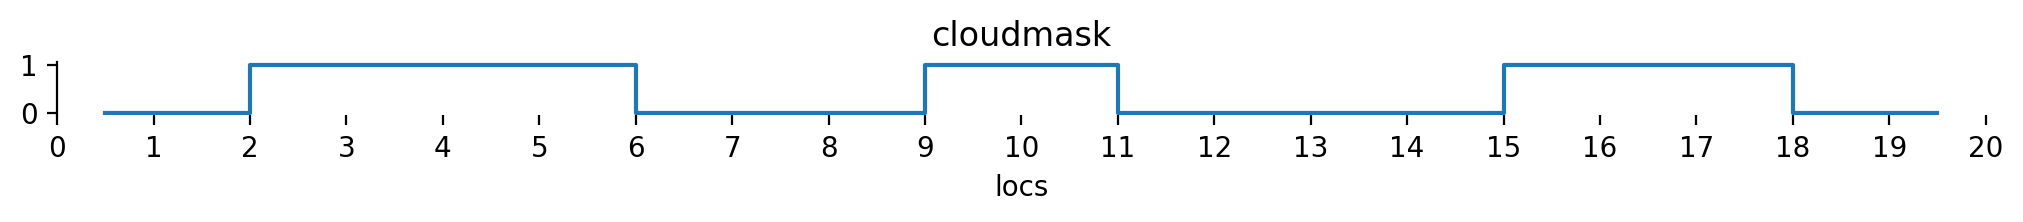

In [3]:
fig, ax = plt.subplots()
ax.step(np.arange(len(cloudmask)) + .5, cloudmask, where='mid')
ax.spines["bottom"].set_visible(False)
ax.set_aspect(.5)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel("locs")
ax.set_xlim(0,20)
ax.set_title("cloudmask");

Based on this flag, it is possible to derive cloud edge locations $E$ by shifting $C$ by one and subtracting from itself:

$$
E_{1...N-1} = C_{1...N-1} - C_{0...N-2}
$$

that way, we end up with three possible values for the edges:

$$
E = \begin{cases}
    1 & \text{start of cloud}\\
    0 & \text{no change}\\
    -1 & \text{end of cloud}
  \end{cases}
$$

These two shifted subsets are best visualized by thinking of two shifts about half a pixel in opposite directions.
Subtracting the two leads to the cloud edges:

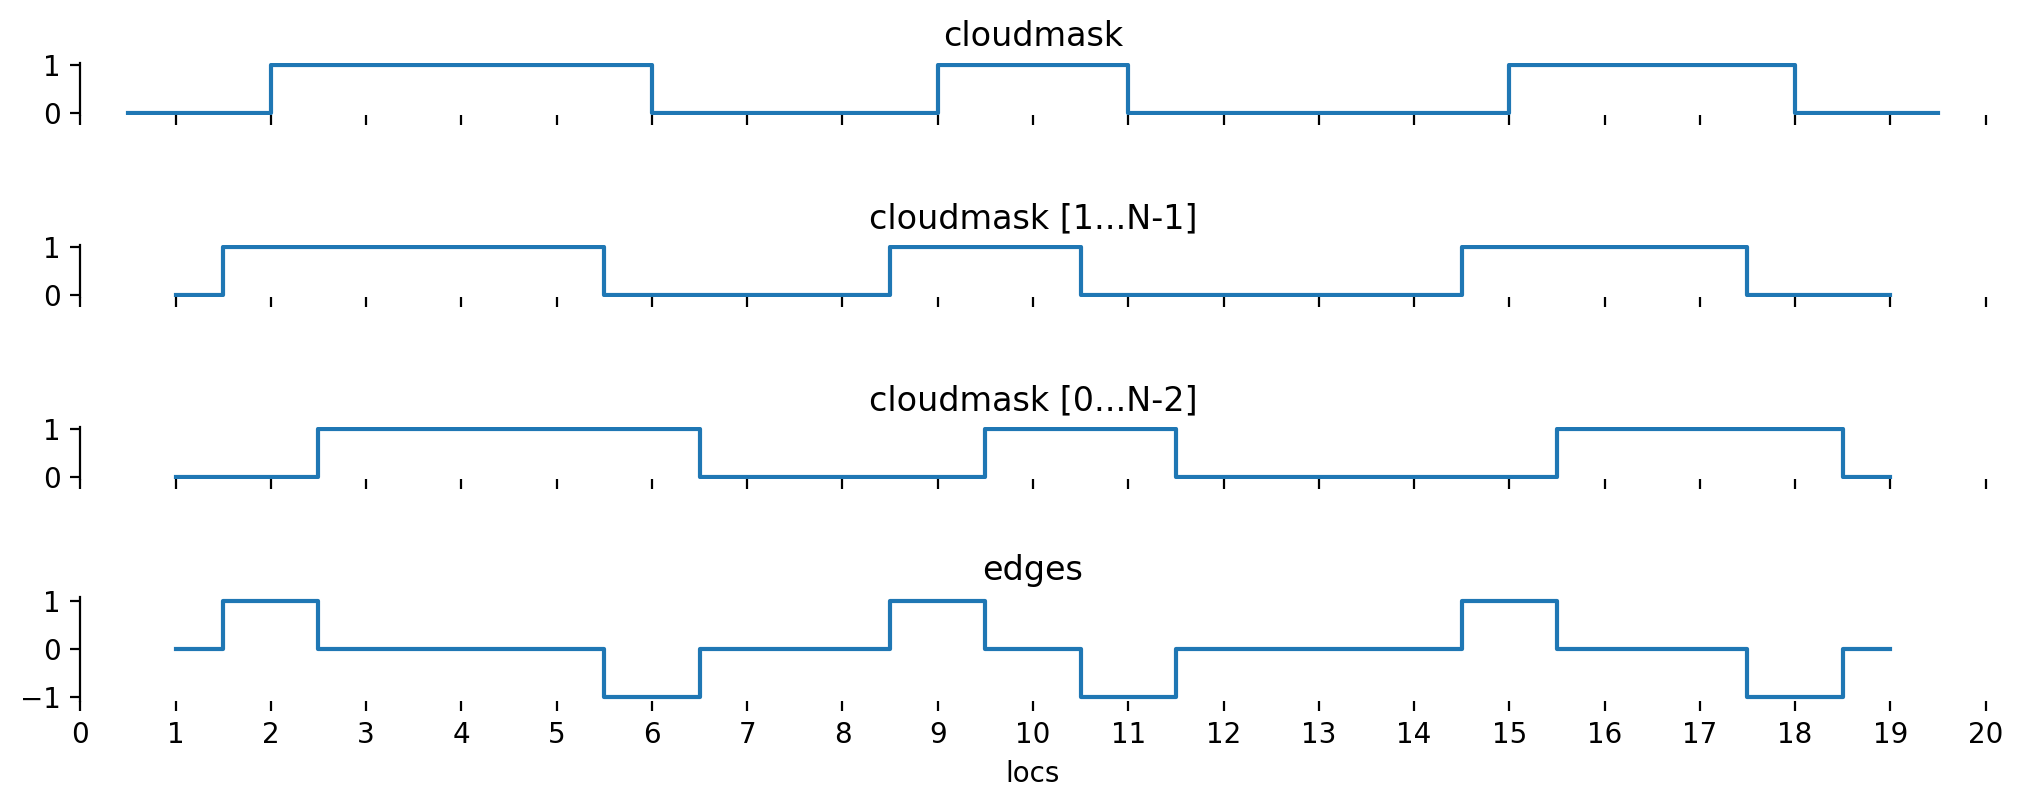

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(10,4))
ax1.step(np.arange(len(cloudmask)) + .5, cloudmask, where='mid')
ax1.spines["bottom"].set_visible(False)
ax1.set_aspect(.5)
ax1.set_title("cloudmask")

ax2.step(np.arange(len(cloudmask) - 1) + 1, cloudmask[1:], where='mid')
ax2.spines["bottom"].set_visible(False)
ax2.set_aspect(.5)
ax2.set_title("cloudmask [1...N-1]")

ax3.step(np.arange(len(cloudmask) - 1) + 1, cloudmask[:-1], where='mid')
ax3.spines["bottom"].set_visible(False)
ax3.set_aspect(.5)
ax3.set_title("cloudmask [0...N-2]")

cloudmask_ = np.asarray(cloudmask, dtype="int")
edges = cloudmask_[1:] - cloudmask_[:-1]
ax4.step(np.arange(len(edges)) + 1, edges, where='mid')
ax4.spines["bottom"].set_visible(False)
ax4.set_aspect(.5)
ax4.set_title("edges")
ax4.set_xlabel("locs")
ax4.set_xlim(0,20)
ax4.xaxis.set_major_locator(ticker.MultipleLocator(1));

```{note}
Shifting both subsets by half a pixel (in stead of shifting one subset by a full pixel) has a deeper meaning: The cloud edges are indeed between the pixels which have been identified as a cloud.
```

If the method would be applied exactly as above, $E$ would be one entry less than the number of pixels. In order to make the following method work properly, we need to extend the edge information to before and after the first and last pixel. We'll set $E_0 = C_0$ (we only start with a cloud if the first pixel is a cloudy one, but don't end a cloud before the first pixel) and $E_N = -C_{N-1}$ (we end a cloud if the last pixel is a cloudy one, but don't start a cloud after the last pixel).

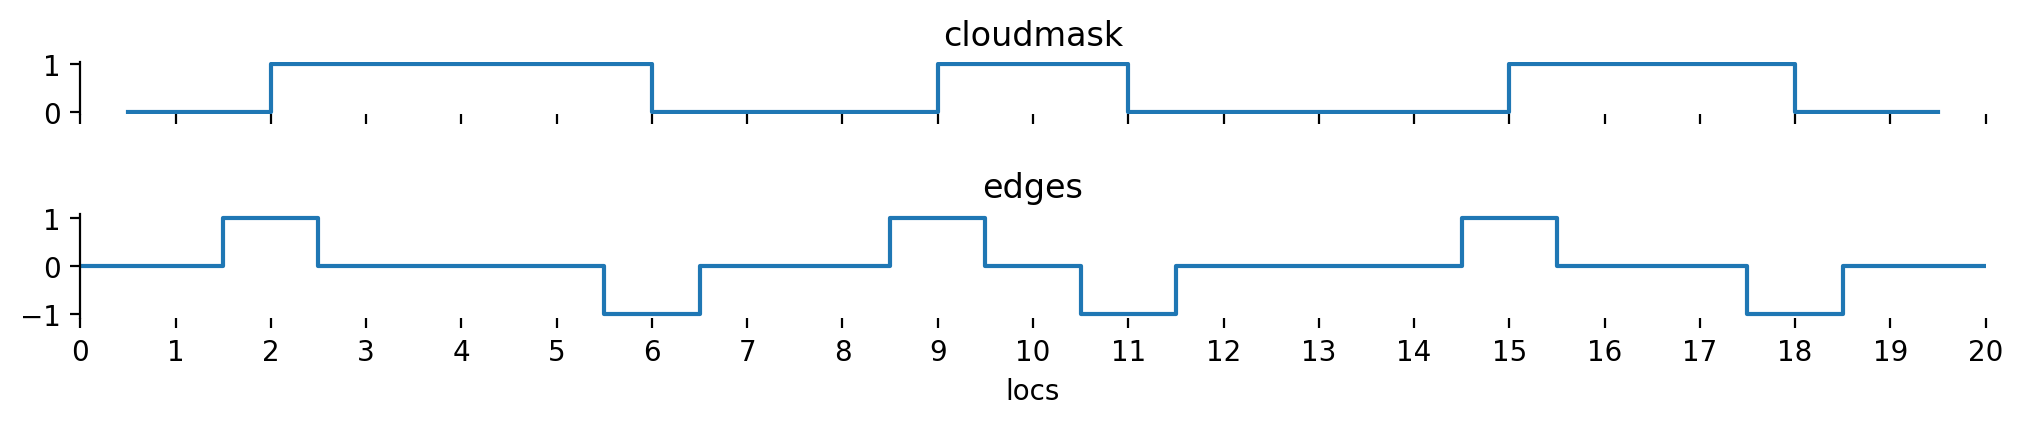

In [5]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,2))
ax1.step(np.arange(len(cloudmask)) + .5, cloudmask, where='mid')
ax1.spines["bottom"].set_visible(False)
ax1.set_aspect(.5)
ax1.set_title("cloudmask")


cloudmask_ = np.asarray(cloudmask, dtype="int")
edges = np.concatenate([cloudmask_[:1], cloudmask_[1:] - cloudmask_[:-1], -cloudmask_[-1:]])
ax2.step(np.arange(len(edges)), edges, where='mid')
ax2.spines["bottom"].set_visible(False)
ax2.set_aspect(.5)
ax2.set_title("edges")
ax2.set_xlabel("locs")
ax2.set_xlim(0,20)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1));

Let's also have a look at a graphical representation of what we have done so far:
```{figure} figures/cloud_segment_length.png
:alt: computing cloud segment length
:width: 100%
:align: center
```

Based on $E$, we can extract a boolean array of cloud start ($E == 1$) and cloud end ($E == -1$) locations.
Based on these two boolean arrays, in particular the indices of the `True` entries, we can compute a cloud length in index space:

In [6]:
def cloud_lengths(cloudmask):
    cloudmask = np.asarray(cloudmask, dtype="int")
    edges = np.concatenate([cloudmask[:1], cloudmask[1:] - cloudmask[:-1], -cloudmask[-1:]])
    starts, = np.where(edges == 1)  # note that np.where returns a one-element tuple
    ends, = np.where(edges == -1)   # we unpack it using ,=

    return ends - starts

Let's try our new method based on the cloud mask from our example.

In [7]:
cloud_lengths(cloudmask)

array([4, 2, 3])

It works just as we expected.

## Segment statistics

Now that we know how to separate consecutive cloudy segments from our trajectory data, it might be useful to aggregate data for each cloudy segment. We want to do this using a similar approach, but one thing is different: we do need to care about each individual data point within a cloud, so we need to do many aggregations across differently sized sets of data. That is not something which seems to be expressible in a vectorized way at first sight. Nonetheless, there are some ways of accomplishing our goal.

One approach to this problem is the [split - apply - combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) approach, which is what among others, `xarray`, `pandas` and SQL provide.
The idea is that we group our data into common sections (those would be one group per individual cloud) and then run a function (which reduces some data to a single value) on each group individually.
The return values from each group are combined into a final result.
While this is a neat way to think about the problem, it has a major drawback when applied to `xarray` or `pandas`: it is really slow.
The method is just a sneaky way of running a for loop over all clouds and thus deliberately avoids the use of `numpy` to speed things up.

But we can still look at the structure of such an operation and then think about how we could do something similar with better performance.
So first, we need some way of identifying each individual cloud.
We'll do this by introducing another array.
We can create such an array by applying the cumulative sum on the absolute value of the edges $E$.
This will also assign individual identifiers to cloud free parts, but that's fine, we can filter them out afterwards.
For now, we'll call this array `section_id` to distinguish between all data split up in sections and the (cloud-only) segments mentioned before.
If we can then find a way to accumulate data into individual bins based on the `section_id`, we should be ready to compute further statistics.

In [8]:
section_ids = np.cumsum(np.abs(edges[:-1]))

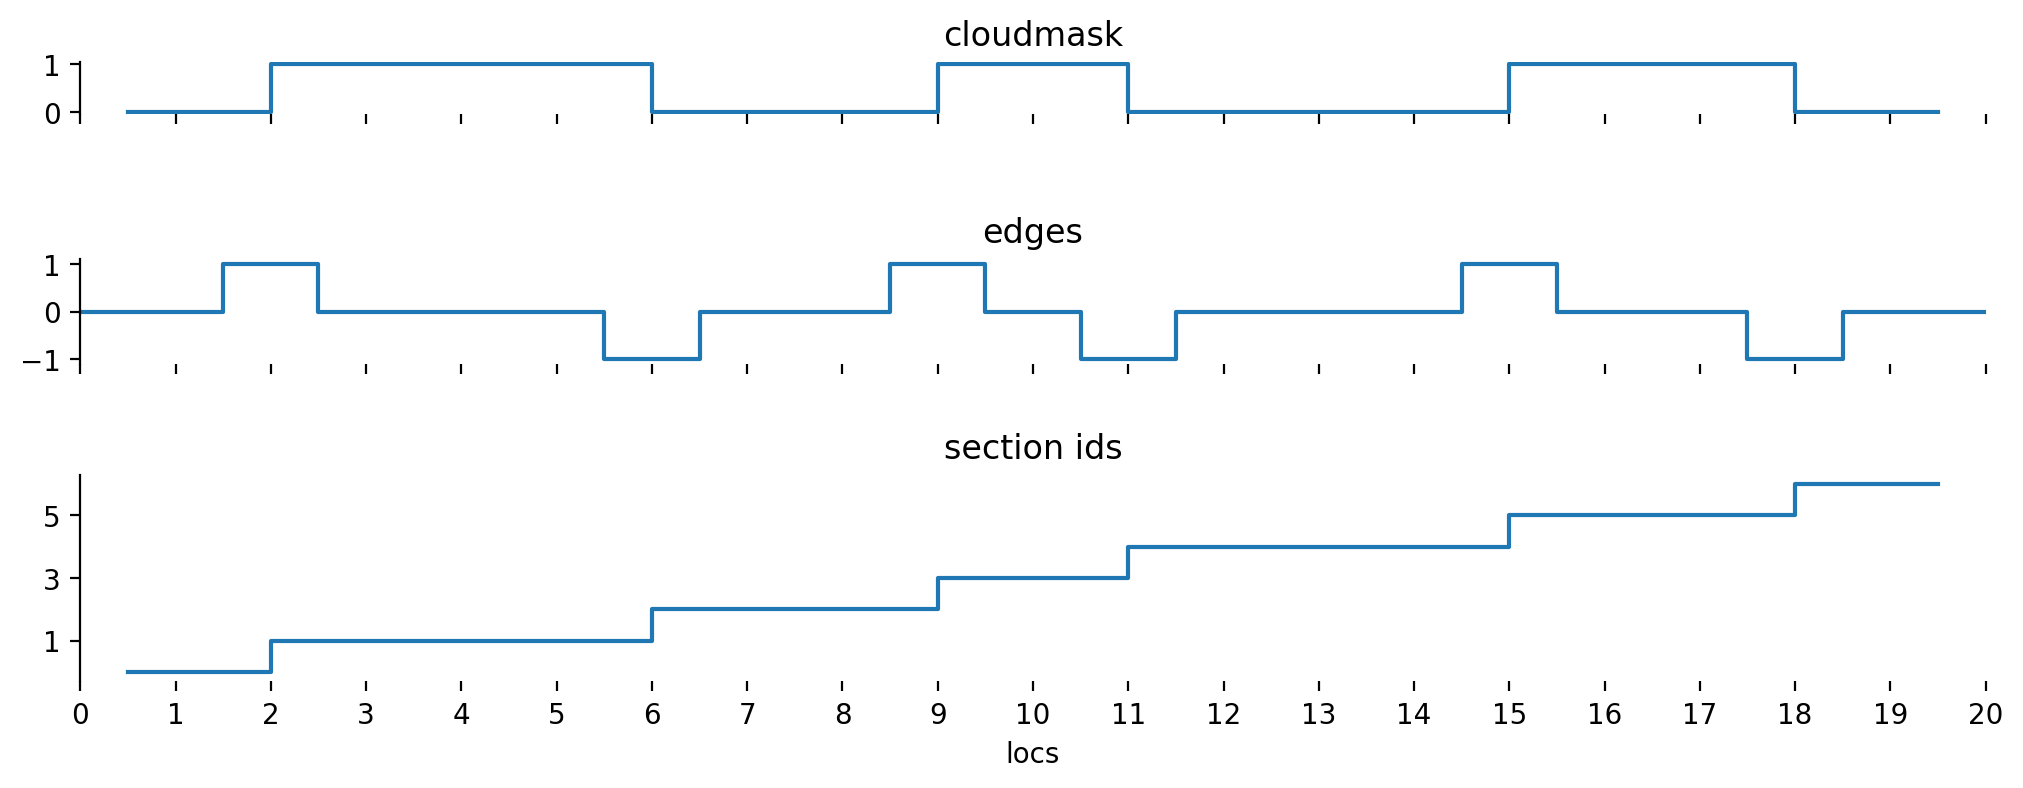

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.step(np.arange(len(cloudmask)) + .5, cloudmask, where='mid')
ax1.spines["bottom"].set_visible(False)
ax1.set_aspect(.5)
ax1.set_title("cloudmask")

ax2.step(np.arange(len(edges)), edges, where='mid')
ax2.spines["bottom"].set_visible(False)
ax2.set_aspect(.5)
ax2.set_title("edges")

ax3.step(np.arange(len(section_ids)) + .5, section_ids, where='mid')
ax3.spines["bottom"].set_visible(False)
#ax3.set_aspect(.5)
ax3.set_title("section ids")
ax3.set_xlabel("locs")
ax3.set_xlim(0,20)
ax3.yaxis.set_major_locator(ticker.IndexLocator(base=2, offset=1))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(1));

Let's have a look at the whole process idea in a graphical way:
```{figure} figures/cloud_segment_stats.png
:alt: computing cloud segment statistics
:width: 100%
:align: center
```

Let's say we want to compute the average optical thickness of each detected cloud segment.
For this example, we assume the following optical thickness per source pixel:

In [10]:
ot = np.array([0., 0., 1., 2., 4., 5., 0., 0., 0., 2., 2., 0., 0., 0., 0., 1., 1., 1., 0., 0.])

We already know how many pixels are part of the cloud (the cloud length from above), so we only need the sum of the optical thickness within the segment in order to compute the mean.
Thus, what we conceptually want to do is:
```python
ot_sum[section_ids] += ot
```
But `+=` will only work correctly if none of the index values from `section_ids` are duplicated, which definitely is not the case, as we designed `section_ids` such that it will contain the same value for every pixel within the same cloud.
Fortunately `numpy` provides [`ufunc.at`](https://numpy.org/doc/stable/reference/generated/numpy.ufunc.at.html) which solves this exact problem.
The `at` method is available for all scalar universal functions of `numpy` which take two arguments and is intended for repeated in-place application of the given universal function.
Addition (`add`) is such a scalar ufunc with two arguments, so we can use `np.add.at` in this case:

In [11]:
ot_sum = np.zeros(np.max(section_ids) + 1)
np.add.at(ot_sum, section_ids, ot)
ot_sum

array([ 0., 12.,  0.,  4.,  0.,  3.,  0.])

````{note}
Observe how
```python
np.add.at(ot_sum, section_ids, ot)
```
can be used as a direct replacement for
```python
ot_sum[section_ids] += ot
```
However, though the latter is simpler to understand, only `np.add.at` will provide the correct results.
````

As indicated above, the result will contain values for each clear and cloudy segment.
In order to compute the final mean cloud optical thickness, we simply can use every odd element of `ot_sum` (those are the cloudy pieces) and divide them by cloud length:

In [12]:
ot_sum[1::2] / cloud_lengths(cloudmask)

array([3., 2., 1.])

which is indeed the average optical thickness of the three detected clouds.

```{note}
While taking every odd element might seem to be a special case (what if the first pixel ist cloudy?), it is in fact the general case. As we've set $E_0 = C_0$, the very first edge entry will mark the start of a cloud in this case and thus the first `section_id` (the cumulative sum) will be 1 in stead of 0 and thus odd as well.
```

## Further generalizations

If we would have computed the cloud lengths not based on the index locations of the cloud edges, but instead based on the position along the flight path (e.g. in meters), this method can be generalized to unevenly spaced datasets.
Furthermore, if we would multiply the pixel optical thickness by the size of the pixel, the same method as above could be used to compute distance weighted averages of cloud parameters.